In [9]:
 #! pip install geopandas

In [52]:
%load_ext autoreload
%autoreload 2
import pdb
import geopandas as gpd
from datetime import date, datetime, timedelta
import requests
import os
import psycopg2
import sys
sys.path.append('/home/ec2-user/SageMaker/adse/lib')
sys.path.append('/Users/schultes/PycharmProjects/adse/lib')
sys.path.append('/home/ec2-user/SageMaker/calval-etl/utilities/')

import io 
import pandas as pd
import numpy as np
import boto3
import os

from datetime import datetime
from pytz import timezone
import pytz

#Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns

#plotly
import plotly.express as px
import plotly.graph_objects as go

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
#! pip install sentry_sdk

In [54]:
from db_utilities import *
from df_utilities import *
from twc_utilities import *
from s3_utilities import *
from quicksight_utilities import trigger_quicksight_dataset_refresh
from arable_logging import logging, DSException
from analytics_utilities import *

from joining import *
from quicklook import *

ModuleNotFoundError: No module named 'quicklook'

In [55]:
DEFAULT_BUCKET = "tbelow-model-development"

def df_to_s3(df, key, bucket=DEFAULT_BUCKET, verbose=True):
    # write DF to string stream
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index=False)
    # write stream to S3
    s3 = boto3.client("s3")
    s3.put_object(Bucket=bucket, Key=key, Body=casv_buffer.getvalue())
    if verbose:
        print(f"Uploaded file to s3://{bucket}/{key}")
        
def df_from_s3(key, bucket=DEFAULT_BUCKET, **kwargs):
    """read csv from S3 as pandas df
    Arguments:
        key - key of file on S3
        bucket - bucket of file on S3
        **kwargs - additional keyword arguments to pass pd.read_csv()
    Returns:
        df - pandas df
    """
    s3 = boto3.client("s3")
    csv_obj = s3.get_object(Bucket=bucket, Key=key)
    body = csv_obj["Body"]
    csv_string = body.read().decode("utf-8")
    df = pd.read_csv(io.StringIO(csv_string), **kwargs)
    return df

def list_keys(prefix="", bucket=DEFAULT_BUCKET):
    """return list of files with specific S3 prefix"""
    bucket_resource = boto3.resource("s3").Bucket(bucket)
    key_list = [file.key for file in bucket_resource.objects.filter(Prefix=prefix)]
    return key_list

def df_from_s3_wColumns(key, cols, bucket=DEFAULT_BUCKET,  **kwargs):  # modify to **kwargs
    """read csv with specific columns from S3 as pandas df
    Arguments:
        key - key of file on S3
        bucket - bucket of file on S3
        cols -columns 
        **kwargs - additional keyword arguments to pass pd.read_csv()
    Returns:
        df - pandas df
    """
    s3 = boto3.client("s3")
    csv_obj = s3.get_object(Bucket=bucket, Key=key)
    body = csv_obj["Body"]
    csv_string = body.read().decode("utf-8")
    df = pd.read_csv(io.StringIO(csv_string), skipinitialspace=True, usecols=cols, **kwargs)
    return df

### Part 1. Reference data table EDA
-- load reference data from local instance or from S3 

In [36]:
# load reference data from local instance folder
local_storage_path='./data_store/reference_data.csv'
reload=False  # need to change to True if we want to reload data from S3 or local path
if not reload:
    reference_data=pd.read_csv(local_storage_path)
else:
    reference_data=pd.read_csv("s3://tbelow-model-development/data/raw/all_raw_reference_data.csv", low_memory=False)
    reference_data.to_csv(local_storage_path, index=False)

KeyboardInterrupt: 

In [56]:
round(reference_data.duplicated().sum()/len(reference_data),2)

0.0

In [57]:
print(f'shape of reference data before drop duplicates {reference_data.shape}')
reference_data.drop_duplicates(inplace=True)
print(f'shape of reference data after drop duplicates {reference_data.shape}')

shape of reference data before drop duplicates (7389268, 7)
shape of reference data after drop duplicates (7389268, 7)


In [58]:
print(f'reference data site_id value counts')
print(reference_data.site_id.value_counts())
print('')
print(f'reference data source value counts')
print(reference_data.source.value_counts())

reference data site_id value counts
US-ARM         1458553
NREL           1399680
AU-Rgf          687989
Manila          633350
neon_wood       469332
neon_guan       430291
neon_puum       410818
Burdette        397038
neon_srer       312402
US-Bi1          262013
US-Var          256337
US-Bi2          250743
Lyon_arb        101691
JF_San_Jose      91503
HQF              91232
UCD_Tomato       79820
Yara             56476
Name: site_id, dtype: int64

reference data source value counts
neon_sensor_package_1min    1622843
arm_radiometry_suite        1458553
nrel_sensor_suite           1399680
au_rgf_sensor_suite          687989
manila_sensor_suite          633350
burdette_sensor_suite        397038
us_bi1_sensor_suite          262013
us_var_sensor_suite          256337
us_bi2_sensor_suite          250743
zentra                       182735
lyon_arb_sensor_suite        101691
growers_standard              56476
ET75                          39999
ET100                         39821
Name:

#### Change data format

In [59]:
#Change data type
reference_data['ref_time'] = pd.to_datetime(reference_data['ref_time'], errors ='coerce') ## invalid parsing will be NAN ( coerce)
reference_data.source=pd.Categorical(reference_data.source)
reference_data.site_id=pd.Categorical(reference_data.site_id)

In [60]:
reference_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7389268 entries, 0 to 47301823
Data columns (total 7 columns):
 #   Column      Dtype              
---  ------      -----              
 0   ref_time    datetime64[ns, UTC]
 1   ref_tair    float64            
 2   ref_lwuw    float64            
 3   ref_lwdw    float64            
 4   ref_tbelow  float64            
 5   site_id     category           
 6   source      category           
dtypes: category(2), datetime64[ns, UTC](1), float64(4)
memory usage: 352.3 MB


### Reference Data visual QC
    quicklook helper functions inventory:

    1.fix_time_index(df, time): fix time index
    2.plothist(df): plot all histograms
    3.corrm(df): generate heatmap for correlation matrix for continous features
    4.quick_look(df, cat_name, cats, props): generate line plots for specific sites or devices
    5.quick_look2(df, cat_name, cats, props, props1,tstart,tend)
    6.lineplots(prod_ref, site, device, log1, log2)

In [61]:
# define get list of site names
site_id=reference_data.site_id.value_counts().reset_index()
cats=list(site_id.iloc[:,0]) 

In [62]:
cats

['US-ARM',
 'NREL',
 'AU-Rgf',
 'Manila',
 'neon_wood',
 'neon_guan',
 'neon_puum',
 'Burdette',
 'neon_srer',
 'US-Bi1',
 'US-Var',
 'US-Bi2',
 'Lyon_arb',
 'JF_San_Jose',
 'HQF',
 'UCD_Tomato',
 'Yara']

### Use Helper function for data visual QC
#### Stored in quicklook.py which should be imported prior use
#1. to use helper functions need to set time as index using following fix_time_index function

### Handle outliers

In [63]:
# top level cleanup
reference_data.loc[((reference_data['ref_tair']<-100)  | (reference_data['ref_tair']>=100)), 'ref_tair'] = np.nan
reference_data.loc[((reference_data['ref_lwuw']<-1000)  | (reference_data['ref_lwuw']>=1000)), 'ref_lwuw'] = np.nan
reference_data.loc[((reference_data['ref_lwdw']<-500)  | (reference_data['ref_lwdw']>=1000)), 'ref_lwdw'] = np.nan

In [64]:
# checking missing data percentage
reference_data.isnull().sum()/len(reference_data)

ref_time      0.000000
ref_tair      0.224179
ref_lwuw      0.047074
ref_lwdw      0.046482
ref_tbelow    0.956825
site_id       0.000000
source        0.000000
dtype: float64

<AxesSubplot:>

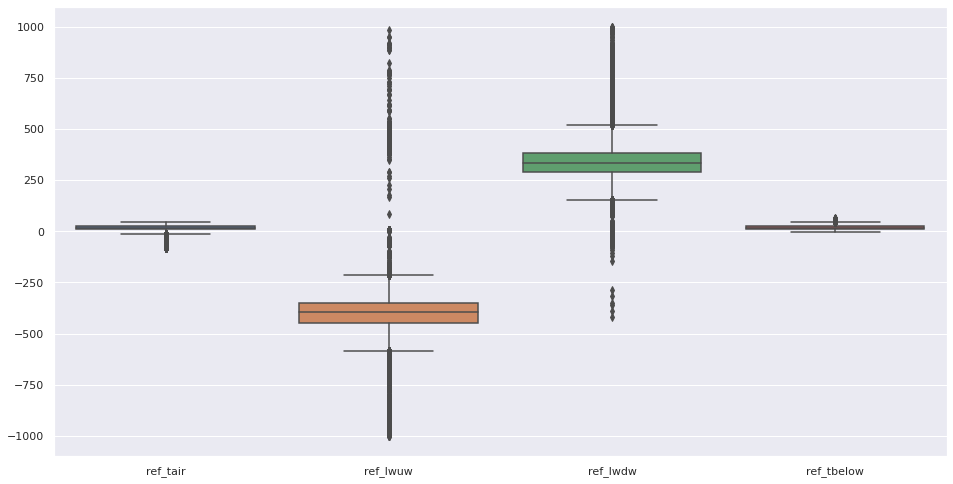

In [65]:
float_v=reference_data[['ref_tair', 'ref_lwuw', 'ref_lwdw', 'ref_tbelow']]
df=reference_data[['ref_tair', 'ref_lwuw', 'ref_lwdw', 'ref_tbelow']]
# plothist(df)

sns.set(rc={'figure.figsize':(16,8.27)})
plt.tight_layout()
float_v=df.columns.to_list()
sns.boxplot(data=reference_data[float_v])

### Correlation Matrix

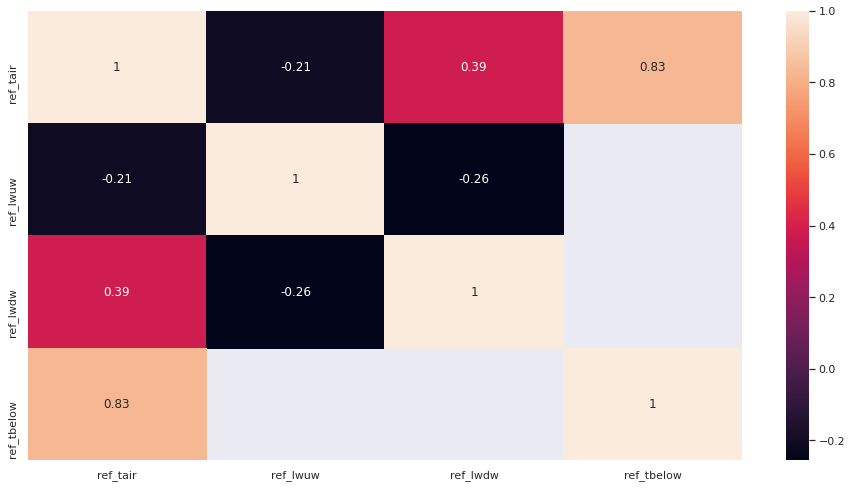

In [66]:
# printmd('**independent and dependent variables, which features have high correlation with dependent var. and how about colinearlity?**')
features=float_v
corrm = reference_data[features].corr()
sns.heatmap(corrm, annot=True)
plt.show()

### Cross plot for large dataset using hexbin

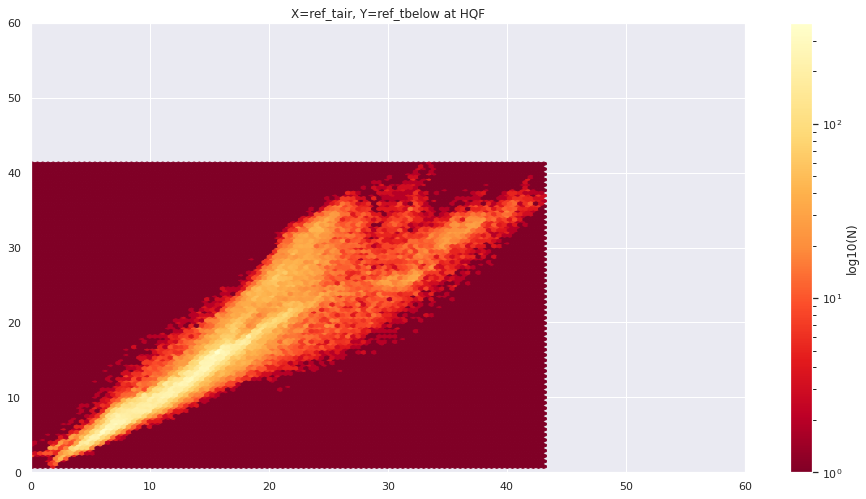

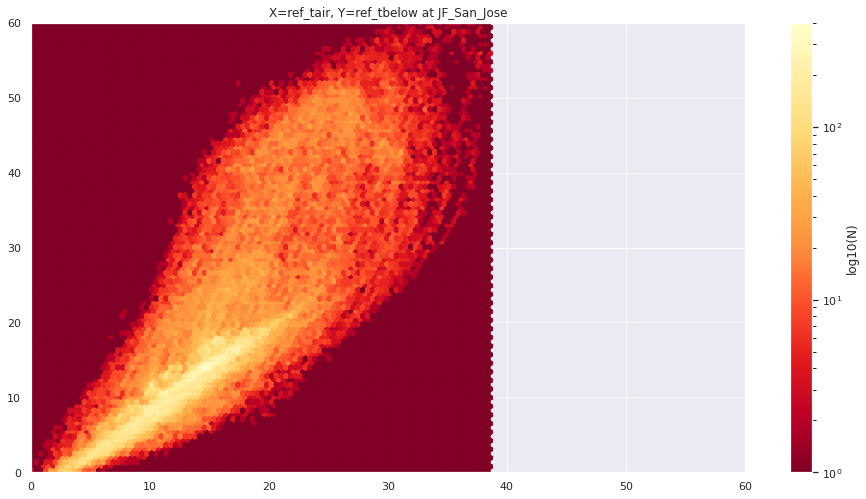

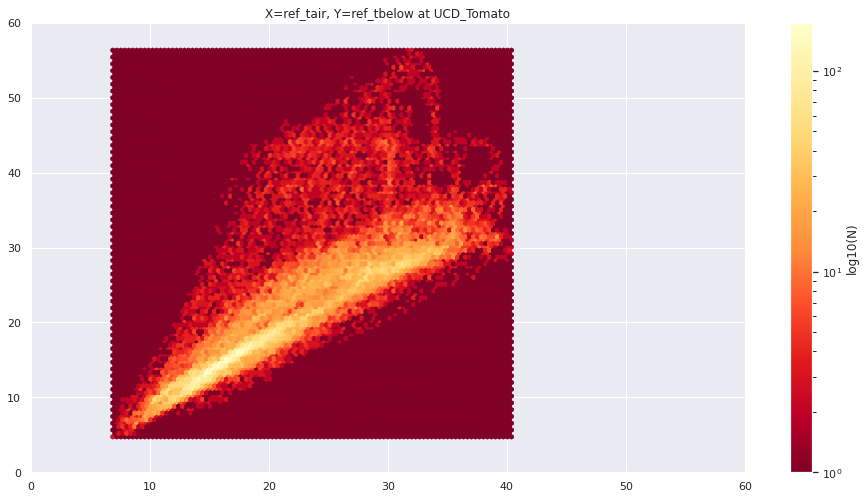

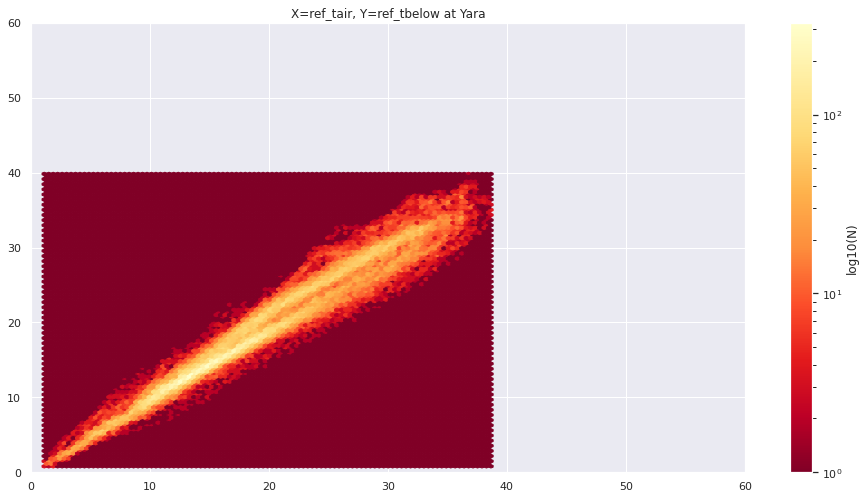

In [67]:
# sites=['AU-Rgf', 'Burdette', 'HQF', 'JF_San_Jose', 'Lyon_arb', 'Manila', 'NREL', 'UCD_Tomato', 'US-ARM', 'US-Bi1', 'US-Bi2', 'US-Var', 'Yara', 'neon_guan', 'neon_puum', 'neon_srer', 'neon_wood']
sites=[ 'HQF', 'JF_San_Jose',  'UCD_Tomato', 'Yara']

for site in sites:
    X=reference_data[reference_data.site_id==site]['ref_tair']
    Y=reference_data[reference_data.site_id==site]['ref_tbelow']
    plt.axis([0, 60, 0, 60])
    plt.hexbin(X,Y,bins='log', cmap=plt.cm.YlOrRd_r)

    plt.title(f"X=ref_tair, Y=ref_tbelow at {site}")

    cb = plt.colorbar()
    cb.set_label('log10(N)')
    plt.show()

### Part2. Load mark data files for data QC and EDA

In [68]:
#read in all mark data
#convert time to datetime; site_id and source
all_mark_file_keys=list_keys(prefix="data/raw/mark_device_data/", bucket=DEFAULT_BUCKET)

In [69]:
all_mark_file_keys

['data/raw/mark_device_data/C003017.csv',
 'data/raw/mark_device_data/C003188.csv',
 'data/raw/mark_device_data/C003231.csv',
 'data/raw/mark_device_data/C003240.csv',
 'data/raw/mark_device_data/C003251.csv',
 'data/raw/mark_device_data/C003405.csv',
 'data/raw/mark_device_data/C004183.csv',
 'data/raw/mark_device_data/C004196.csv',
 'data/raw/mark_device_data/C004251.csv',
 'data/raw/mark_device_data/C004830.csv',
 'data/raw/mark_device_data/C004854.csv',
 'data/raw/mark_device_data/C004880.csv',
 'data/raw/mark_device_data/C004919.csv',
 'data/raw/mark_device_data/C004944.csv',
 'data/raw/mark_device_data/C004988.csv',
 'data/raw/mark_device_data/C005397.csv',
 'data/raw/mark_device_data/C006108.csv',
 'data/raw/mark_device_data/C006123.csv',
 'data/raw/mark_device_data/C006126.csv',
 'data/raw/mark_device_data/C006158.csv',
 'data/raw/mark_device_data/C006160.csv',
 'data/raw/mark_device_data/C006163.csv',
 'data/raw/mark_device_data/C006164.csv',
 'data/raw/mark_device_data/C00617

In [ ]:
###Load selected mark features

In [70]:
#selected features for modeling based on team discussion 12/14/2021
mark_features=['time','site','device','location',
               'lw_temp_2', 'lw_temp_3', 'swdw', 'swuw', 'b6uw', 'b4uw','b1uw',
               'lat.1', 'long.1']

In [72]:
#concat tables for QC and EDA  modified the code to load selected features -12/15/2021
mark_data = pd.concat([df_from_s3_wColumns(file_key, mark_features) for file_key in all_mark_file_keys])

In [73]:
# tranform data types after loading from S3
mark_data.time = pd.to_datetime(mark_data.time, errors='coerce')
# Change data type
mark_data.device=pd.Categorical(mark_data.device)
mark_data.site=pd.Categorical(mark_data.site)
mark_data.location=pd.Categorical(mark_data.location)

### Check duplicate and missing value percentage

In [74]:
mark_data.duplicates()

AttributeError: 'DataFrame' object has no attribute 'duplicates'